# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

## Define neural network

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# class QNetwork(nn.Module):
#     def __init__(self, state_size, action_size, seed, *args):
#         super().__init__()
#         self.seed = torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, action_size)
        
#     def forward(self, state):
#         print('Forward')
#         state = F.relu(self.fc1(state))
#         state = F.relu(self.fc2(state))
#         state = self.fc3(state)
#         return state
    
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_layer_sizes=[]):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.fc_layers = nn.ModuleList()
        layer_sizes = [state_size] + list(hidden_layer_sizes) + [action_size]
        for size1, size2 in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(size1, size2))
        
    def forward(self, state):
        for layer in self.fc_layers[:-1]:
            state = F.leaky_relu(layer(state))
        state = self.fc_layers[-1](state)
        return state

## Define agent

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)
from collections import namedtuple, deque
import random

# Uses the Double q-learning method to learn
class DQN_Agent:
    def __init__(self, state_size, action_size, seed,
                 buffer_size = int(300 * 1e5),
                 batch_size = 512,
                 gamma = 0.99,
                 learning_rate = 5e-3,
                 update_every = 20,
                 tau = 2e-2,
                 middle_layers = [32, 32]):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.update_every = update_every
        self.tau = tau
        self.middle_layers = middle_layers
        
        self.qnetwork = QNetwork(state_size, action_size, seed, middle_layers).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, middle_layers).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)
        
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        
        self.time_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.time_step = (self.time_step + 1) % self.update_every
        if self.time_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
                
    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork.eval()
        with torch.no_grad():
            action_values = self.qnetwork(state).max(1)[1]
        self.qnetwork.train()
        
        if random.random() > eps:
            return action_values.cpu().numpy()
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        next_qs = self.qnetwork(next_states).detach()
        next_qs_target = self.qnetwork_target(next_states).detach()
        max_next_qs, best_next_actions = next_qs.max(1, keepdim=True)
        
        q = self.qnetwork(states).gather(1, actions)
        q_next = next_qs_target.gather(1, best_next_actions)  # Double q-learning step
        
        loss = F.mse_loss(rewards + gamma * q_next * (1 - dones), q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork, self.qnetwork_target, self.tau)
        
        # Update
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def values(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork.eval()
        with torch.no_grad():
            action_values = self.qnetwork(state).squeeze(1)
        self.qnetwork.train()
        return action_values.cpu().numpy()
    
    def save(self, location):
        torch.save(self.qnetwork_target.state_dict(), location)
        
    def load(self, location):
        self.qnetwork.load_state_dict(torch.load(location))
        self.qnetwork_target.load_state_dict(torch.load(location))
        
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

Using device cuda:0


### Make the agent

In [9]:
agent = DQN_Agent(state_size=state_size, action_size=action_size, seed=0)

### Train the agent

<IPython.core.display.Javascript object>


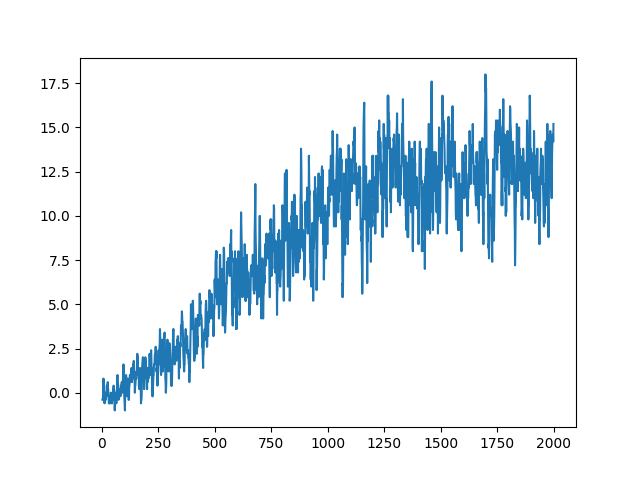

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

1.0
0.999
0.998
0.997
0.996
0.995
0.994
0.993
0.992
0.991
0.99
0.989
0.988
0.987
0.986
0.985
0.984
0.983
0.982
0.981
0.98
0.979
0.978
0.977
0.976
0.975
0.974
0.973
0.972
0.971
0.97
0.969
0.968
0.967
0.966
0.965
0.964
0.963
0.962
0.961
0.96
0.959
0.958
0.957
0.956
0.955
0.954
0.953
0.952
0.951
0.95
0.949
0.948
0.947
0.946
0.945
0.944
0.943
0.942
0.9410000000000001
0.94
0.9390000000000001
0.938
0.937
0.9359999999999999
0.935
0.9339999999999999
0.933
0.9319999999999999
0.931
0.9299999999999999
0.929
0.928
0.927
0.926
0.925
0.924
0.923
0.922
0.921
0.92
0.919
0.918
0.917
0.916
0.915
0.914
0.913
0.912
0.911
0.91
0.909
0.908
0.907
0.906
0.905
0.904
0.903
0.902
0.901
0.9
0.899
0.898
0.897
0.896
0.895
0.894
0.893
0.892
0.891
0.89
0.889
0.888
0.887
0.886
0.885
0.884
0.883
0.882
0.881
0.88
0.879
0.878
0.877
0.876
0.875
0.874
0.873
0.872
0.871
0.87
0.869
0.868
0.867
0.866
0.865
0.864
0.863
0.862
0.861
0.86
0.859
0.858
0.857
0.856
0.855
0.854
0.853
0.852
0.851
0.85
0.849
0.848
0.847
0.846
0.845
0.8

0.19099999999999995
0.18999999999999995
0.18899999999999995
0.18799999999999994
0.18700000000000006
0.18600000000000005
0.18500000000000005
0.18400000000000005
0.18300000000000005
0.18200000000000005
0.18100000000000005
0.18000000000000005
0.17900000000000005
0.17800000000000005
0.17700000000000005
0.17600000000000005
0.17500000000000004
0.17400000000000004
0.17300000000000004
0.17200000000000004
0.17100000000000004
0.17000000000000004
0.16900000000000004
0.16800000000000004
0.16700000000000004
0.16600000000000004
0.16500000000000004
0.16400000000000003
0.16300000000000003
0.16200000000000003
0.16100000000000003
0.16000000000000003
0.15900000000000003
0.15800000000000003
0.15700000000000003
0.15600000000000003
0.15500000000000003
0.15400000000000003
0.15300000000000002
0.15200000000000002
0.15100000000000002
0.15000000000000002
0.14900000000000002
0.14800000000000002
0.14700000000000002
0.14600000000000002
0.14500000000000002
0.14400000000000002
0.14300000000000002
0.14200000000000002


In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import deque

%matplotlib  inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
action_axes = [fig.add_subplot(111) for action in range(action_size)]
plt.ion()
#fig.show()
fig.canvas.draw()

num_episodes = 2000
episodes = []
smoothing_buffer = 5
scores = deque(maxlen=smoothing_buffer)
means = []
action_values = [[] for i in range(action_size)]
for i in tqdm(range(num_episodes)):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    initial_state = state
    score = 0                                          # initialize the score
    moves = 0
    explore_rate = max((1 - i / num_episodes*2), .05)  # linear for half of the time, .05 for the other half
    print(explore_rate)
    
    while True:
        action = agent.act(state, explore_rate)                  # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = int(env_info.local_done[0])             # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        values = agent.values(state)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        moves += 1
        if done:                                       # exit loop if episode finished
            break
    
    scores.append(score)
    values = agent.values(initial_state)
    if len(scores) == smoothing_buffer:
        episodes.append(i)
        means.append(np.mean(scores))
        for action_num in range(len(values)):
            action_values[action_num].append(values[action_num])
        if i % 1 == 0:
            ax.clear()
            ax.plot(episodes, means)
#             for action in range(action_size):
#                 ax.plot(episodes, action_values[action])
#                 ax.legend()
            
            fig.canvas.draw()
agent.save('q_checkpoint.pt')
    

## Discussion on future work

There are several things I wanted to try that I didn't have to in order to get this to work.
I am curious what would happen ono a much larger neural network. Let's say a nerual net with 10 middle layers of size 128 a piece. I didn't get to try this because of time and GPU size restrictions, but it's an experiment that I think is worth trying.

The other thing I think would help this implementation quite a bit is picking experience that the agent will learn from more (prioritized experience replay). Through the current implementation, I think the last bit of data has the agent doing the same thing over and over, which is good for getting through the last push of finding a great policy after it's done some exploration, but has the drawback of looking at the same examples over and over. Choosing which of those examples to look at intelligently could potentially really help this implementation.